# Sedaro Studies Example Notebook 
Demonstrates Sedaro Studies support via the sedaro python client using a Jupyter notebook.

(REMOVE BEFORE PUBLISHING)
> Task 
Where users can adapt them to do their own studies. It should be obvious where the top level override configuration is done as well as the feedback loop (in the case of the Monte Carlo). The notebooks should demonstrate the ability to run many simulations in parallel.  In the monte carlo case, this will be via batches of N sims that are run and then the results pulled and then another N run depending on feedback loop.
- Public jupyter notebooks for:
    - Wildfire Trade Space Analysis: Battery Size vs. Mass
    - Wildfire Monte Carlo: 
        - Vary uncertainty on:
            - Moment of magnetorquers
            - Mass of reaction wheels
            -  Initial position, velocity, and attitude
            - Vary random seeds of sensors by changing simulation-wide seen
        - To understand uncertainty of average pointing error


# Introduction  

This notebook demonstrates how to use the new Studies support added to Sedaro. 
The core of this support is the new API python client object **SimStudy**
**SimStudy** will generate and run a series of *SimJobs* in parallel up to account capacity limits. The remaining simjobs will be placed in a queue and will be execute when resources are available. 
Each *SimJob* of a **SimStudy** will run a baseline Scenario branch with model parameters variations in order to observe their effects on performance results.
Each *SimJob* of a **SimStudy** will set the random seed to a different value in order to generate different output results from the simulation.
**Overrides** takes this a step further by providing a means to adjust any starting value of any model of the simulation using a set of pre-defined functions.

# Setup

Running this notebook requires the following:
- A Sedaro Account            --> https://www.sedaro.com
- A Sedaro API Token          --> https://www.sedaro.com/#/account
- The Wildfire Demo Branch ID --> login --> select/click or create workspace --> select/click Project: [DEMO] WildFire --> select/click  Repositories: [DEMO] Wildfire Scenarios --> copy main branch ID via clipboard icon (TODO insert screen shot)
- Python 3.10+ installed      --> https://www.python.org
- Jupyter notebook or lab     --> https://jupyter.org


## Pip requirements

Create/activate a python venv if desired

In [ ]:
!python -m venv /path/to/new/virtual/environment

Activate it via this table
| Platform | Shell | Command to activate virtual environment |
| :- | :- | :- |
| POSIX | bash/zsh |  source <venv>/bin/activate |
| | fish |  source <venv>/bin/activate.fish |
| | csh/tcsh |  source <venv>/bin/activate.csh |
| | PowerShell |  <venv>/bin/Activate.ps1 |
| Windows | cmd.exe | C:\> <venv>\Scripts\activate.bat |
| | PowerShell | PS C:\> <venv>\Scripts\Activate.ps1 |

Required python modules

In [ ]:
!python -m pip install -e sedaro pytest mathplotlib pandas sweetviz

or replace *python* with *python3* if needed 

!python3 -m pip install -e sedaro pytest mathplotlib pandas sweetviz

Optional module needed by the stats() function if desired 

In [ ]:
!pip3 install sweetviz

Run the following cells to test if all required python modules are installed correctly

In [ ]:
import sedaro
import yaml
import json
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# optional
import sweetviz as sv

## Sedaro python client setup
Note: More information about the sedaro-python client can be found here: [https://github.com/sedaro/sedaro-python]

In the next cell, adjust the following variables as needed
- *Sedaro_api_host*
- *Sedaro_api_token*

In [7]:
Sedaro_api_host  = "http://localhost:80" # "api.sedaro.com"

# Set your API token value either directly or via loading a secrets file
# !! NOTE !!  Be careful not to check in your API Key into a source control repo  !! Note !!
secretPath = '/Users/sedaro/Documents/sedaro/sedaro-satellite/secrets.json'
with open(secretPath, 'r') as file:
    Sedaro_api_token = json.load(file)['API_KEY']
    
sedaroAPI = sedaro.SedaroApiClient(api_key=Sedaro_api_token, host=Sedaro_api_host)

## Load the wildfire scenario branch data

Change the value of the *scenario_branch_id* in the next cell to the branch id noted above during the **Setup** section

In [54]:
scenario_branch_id = "PKNxCWQL8N3cR5CG7YS6X3"
wildfire_scenario_branch = sedaroAPI.scenario(scenario_branch_id)

In [ ]:
# wildfire_scenario_branch.study(sedaroAPI, scenario_branch_id)

# Overview of the Study objects
Existing Study objects of a scenario_branch object can be listed via:  

In [ ]:
wildfire_scenario_branch.study.get_all()

but if this is you first time running this notebook then an empty list will be returned ( [] ).

---
Class methods for the scenario_branch.study Class, along with it's support classes are as follows:


## Study
Create via
```
resource = f'/simulations/branches/{scenario_branch_id}/control/study/'
result = sedaroAPI.request.post(resource,
       body={
            "iterations": 3
            })
```
| Class Method | Arguments  | Returns | Description |
| :-: | :-: | :-: | :- | 
| start | ( iterations: int ) | StudyHandle | Starts study corresponding to the respective Sedaro Scenario Branch id. |
| status | ( job_id: str = None ) | StudyHandle |  Refreshes the local study status. |
| terminate | ( job_id: str = None ) | StudyHandle | Terminate latest running simulation job corresponding to the respective Sedaro Scenario Branch id. |
|  |  |  | If a `job_id` is provided, that simulation job will be terminated rather than the latest. |
| |
| results | (job_id: str = None) | StudyResult | Query latest scenario study result. If a `job_id` is passed, query for corresponding sim results rather than latest. |
| results_poll | ( job_id: str = None, retry_interval: int = 2) | StudyResult | Query latest scenario study result and wait for sim to finish if it's running. | 
| | | | If a `job_id` is passed, query for corresponding study results rather than latest. See `results` method for details on using the `streams` kwarg. |
| |
| stats_results | () | StudyStatsResult | Retuens a 'StudyStatsResult' instance of Statistics based on the study result data |


## StudyHandle

| Class Method | Arguments  | Returns | Description |
| :-: | :-: | :-: | :- | 
| get | (key, default=None) | StudyHandle | Returns a Study handle with the given key |
| status | (err_if_empty: bool = True) | StudyHandle | Refreshes the local study status. |
| terminate | () | StudyHandle | Terminate the running study. |
| |
| results | () | StudyResults | Query study results. |
| results_poll | (retry_interval: int = 2) | StudyResults | Query study results but wait for sim to finish if it's running. See `results` method for details on using the `streams` kwarg. |
| |
| stats_results | () | StudyStatsResult | Returns a StudyStatResult object |

## StudyResults
By default, this class will lazily load simulation results as requested
and cache them in-memory. Different caching options can be enabled with
the .set_cache method.
        
| Class Method | Arguments  | Returns | Description |
| :-: | :-: | :-: | :- | 
| id | () | int | Returns the id of the StudyResult Object |
| branch | () | str | Returns the branch id of the StudyResult Object |
| scenario_hash | () | str | Returns a unique hash |
| status | () | str | xx |
| date_created | () | datetime | xx |
| date_modified | () | datetime | xx |
| job_ids | () | List[int] | Returns a list of SimJob id's created by the Study.start method |
| iterations | () | int | Returns the number of SimJobs created by the Study.start method |
| set_cache | (cache: bool = True, cache_dir: str = None) | None | Set caching options for this study result. |
| | | | cache: Boolean option to turn caching on or off. |
| | | | cache_dir: Path to a directory for on-disk caching. |
| result | (id_: str, streams: Optional[List[Tuple[str, ...]]] = None) | SimulationResult | Query results for a particular simulation. |
| clear_cache | () | None | Clears the cache files in the cache_dir |
| summarize | () | None | Summarize these results in the console.' |


## StudyStatsResults
By default, this class will lazily load simulation results as requested
and cache them in-memory. Different caching options can be enabled with
the .set_cache method.

| Class Method | Arguments  | Returns | Description |
| :-: | :-: | :-: | :- | 
| id | () | int | Returns the id of the StudyResult Object |
| branch | () | str | Returns the branch id of the StudyResult Object |
| scenario_hash | () | str | Returns a unique hash |
| status | () | str | xx |
| date_created | () | datetime | xx |
| date_modified | () | datetime | xx |
| job_ids | () | List[int] | Returns a list of SimJob id's created by the Study.start method |
| iterations | () | int | Returns the number of SimJobs created by the Study.start method |
| set_cache | (cache: bool = True, cache_dir: str = None) | None | Set caching options for this study result. |
| | | | cache: Boolean option to turn caching on or off. |
| | | | cache_dir: Path to a directory for on-disk caching. |
| result | (id_: str, streams: Optional[List[Tuple[str, ...]]] = None) | SimulationResult | Query results for a particular simulation. |
| clear_cache | () | None | Clears the cache files in the cache_dir |
| summarize | () | None | Summarize these results in the console.' |
| stats_results | (_ids=None ) | dict[simjob_id, pandas.dataframe] | Packages the sim results into a dictory of simjob_id to sim results as a pandas dataframe |
| xx | xx | xx | xx |
| xx | xx | xx | xx |
| xx | xx | xx | xx |

# Overview of the overrides feature
Overrides consist of a *path* to the model parameter to change and a *function* to perform the actual change itself.
*Variables* can be used to hold a value of a model parameter or a constant. They are used to ease modification of override values and provide a means to ensure overall model consistancy.
The functions used to change model parameters support tradespace tables, random assignments via the functions located in Pythons Random module.

## What do overrides do?
- Change starting values of model parameters via selected functions
 - Saves these model parameter changes so they can be loaded and re-run later 
- Function random choices are deterministic between simulation runs.



## Paths
An addressing means to access a parameter of an Agents block. Currently there are two versions:
- "**path**": A human readable format based on the names of models and its components. 
 - Format: Agent Name / blockname / parameter name / sub series
 - Example: “Wildfire/Crosslink/minTimeBetweenOccurrences/min”
 - Uses “/“ as a delimiter to mimic file location paths
- "**agent_key**": Based on the ids of a model and its components.
 - Format: agent_id.data.blocks.block_id.parameter.subseries
 - Example: “NT0LWIfSJ1RIenKpUmJEV.data.blocks.NV0bIfUUj9e6l-PX4ql1V.loadDefParams.power”
 - Uses ‘.’ for the separator
 - Similar to how Sedaro results streams are named

## Variables
Used to ensure consistany when assigning random values to parameters For example if the area of a solar panel is randomly assigned, then  

### Built-in Variables
Always available to use as values for function arguments

| Name | Description |
| :-: | :- |
| x |  Replaced by the value in the parameter path before the function is run |
| original | Same as 'x' but more explicit |

### User defined
Defined in the "variables" section of the overrides datastructure

**add overrides structure map here**


or defined as a list of json objects

In [ ]:
wildfire_scenario_branch.Variable

In [32]:
variables = [
        {
            "name": "gyroHotTemp",
            "path": "Wildfire/Gyro/hotTempRating/degC",      
        },
        {
            "name": "gyro_Sandwich",
            "equals": "tasty"
        }
    ]

Variables must have a 'name'
and either:
- a **path** or **Agent_path** which assigned the variable to the parameters starting value
- a **equals** which sets the variable to a given value.
 - This value must be the same type of the parameter, aka string, int, or float
  - A key: value pair is used for paths with sub series
   - Example: { "Degrees": 90 } 
 - Values in arrays or lists must have the index in the path address
 -  

In [33]:
overrides = [
        {
            "path": "Wildfire/Gyro/hotTempRating/degC", # 100.0
            "fn": "=",
            "arg": 90.0
        },
    ...
]

In [34]:
overrides

[{'path': 'Wildfire/Gyro/hotTempRating/degC', 'fn': '=', 'arg': 90.0},
 Ellipsis]

## Available overrides

### fn

Executes the function and places the result into the provided Parameter Path

##### basic math operators +, -, *, /
##### Python random module functions

| Basic Math Operators | Random Module |  |   |   |
| :-: | - | - | - | - |
| + | choices | sample | randrange | uniform |
| - | triangular |expovariate | gammavariate | gauss |
| * | normalvariate | lognormvariate | vonmisesvariate | paretovariate| 
| / | weibullvariate |

Signature:
Varies based on the fn but match the signatures of the python random module itself
The python random module function "WeibullVariate" has the following signature:
```
class WeibullVariate(PathFn):
    fn: Literal["weibullvariate"]
    alpha: int | float | str
    beta:  int | float | str
```
> Do note *str* types in this context are the defined variable name which are replaced by the variable value

Example:
```
{
   "path": "Wildfire/Power Processor/thermalCapacitance",
   "fn": "*", "arg": 1.2
}
```
- Will multiply the value of the value originally lose to the *Wildfire/Power Processor/thermalCapacitance* model parameter by 1.2
- Then it will set the result as the result of the *Wildfire/Power Processor/thermalCapacitance* model parameter

### fn_chain
Performs the provided list of fn overrides in order, each time storing the result in the given parameter path  

Signature:
```
class FnChain(PAthFn):
    fn_chain: List[ possible_fns ]
```

Example:
Given the following **fn_chain** override json
```
{
   "path": "Wildfire/Power Processor/thermalCapacitance",
   "fn_chain": [
          {"fn": "*", "arg": 1.2}, 
          {"fn": "-", "arg": 1.0}, 
          {"fn": "triangular", "low": 4000, "high": 4500, "mode": "x" },
          {"fn": "clamp", "low": 4100} ]
}
```
- Will first multiply the value located in the *thermalCapacitance* parameter of the *Wildfire/Power Processor* model by **1.2**
- Then it will substract **1.0** from the previous result
- Then draw a random value from a *triangular* shaped distribution centered around the **current result** *(x is replaced by the current result)*, with low of **4000** and the high of **4500**
- Then clamp the final result to be **4100** or greater
- the final result is then stored in the *Wildfire/Power Processor/thermalCapacitance* parameter

### sim_index
Used to perform tradespace studies. The StudyJob object will create SimJobs each with an unique index. The **sim_index** override will use this index to select from a list of **fn** overrides to use for that SimJob.

The **sim_index**  is modulated by the size of the provided override fn list
> fn used = fn_list[ int(sim_index)%len(fn_list) ]

Signature
```
class SimIndex(PathFn):
    sim_index: List[ possible_fns ]
```
Example:
Given the following **sim_index** entry JSON 

```
"seed_index": [ 
                {"fn": "uniform",
                  "a": 2900.0, 
                  "b": 3100  },
                {"fn": "=", "arg": 3000.0}, 
                {"fn": "*", "arg": 1.2}, 
             ]
```



### copy_value_to (*Working name*)
Copies the current value of a model parameter into a variable.

Example:

### clamp
Bounds a parameter value to a given range. Meant to be used with a fn_chain to ensure a randomly set vallue is within valid bounds.

Example:

### clampRedo(*coming soon-ish*)
Will rerun an overfunction if the result is outside a given range. Meant to be used with random based override functions.

Example:

# Example Studies

## Wildfire Tradespace Analysis: Battery Size vs. Mass effects on Agent maneuverability
### Optional: Load shared workspace to skip setup and running the study

#### Tradespace table used
#### Overrides used


### Setup

#### Deternmine Parameter Paths

#### Create tradespace table 

| Agent Parameter | Sim Alpha Value | Sim Beta Value | Sim Charlie Value | Parameter Path | Agent_ID_PATH |
| :-: | :-: | :-: | :-: | :-: | :-: |
| Battery Size | 9999 | 8888 | 7777 | xxxx | yyyy |
| Mass | 6666 | 5555 | 4444 | aaaa | bbbb |

- Data sources: 
  - Spec sheets for satellite batteries (https://www.eaglepicher.com/markets/space/satellites/)

In particular:
- Primary Lithium-Ion Cells Space COTS Batteries Offerings from Eaglepicher
  - (https://www.eaglepicher.com/sites/default/files/COTS%201022.pdf):
  - 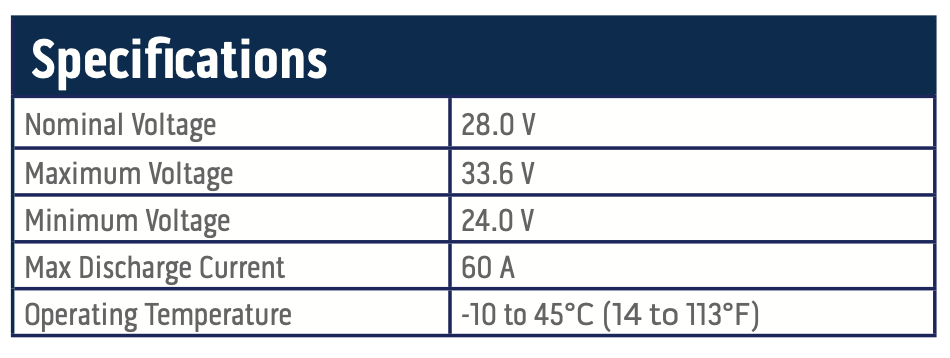
  - 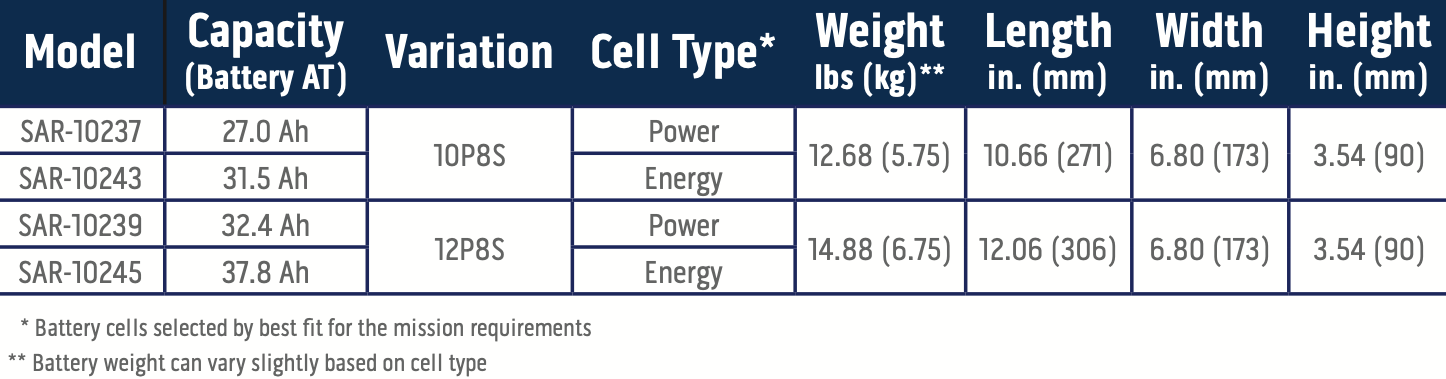

#### Create overrides from tradespace table

In [ ]:
The paths we will be modifying will be
- /wildfire/

In [ ]:
tradespace_overrides_dict = {}

In [ ]:
tradespace_overrides_block = wildfire_branch.OverrideSet.create(**tradespace_overrides_dict)

record the generated override block ID

#### Create Study 

In [ ]:
study_id = 'PK5Z4Mrx8Phf7ZbgGqy4Rr'
study_control_resource = f'/simulations/branches/{scenario_id}/control/study/{study_id}'

### Run Study

In [ ]:
study_status = sedaroAPI.request.get(study_control_resource)

In [ ]:
study_status

In [ ]:
study_job_ids = study_status['jobs']

In [ ]:
[ sedaroAPI.request.get(f'/simulations/branches/{scenario_id}/control/{job_id}') for job_id in study_job_ids]

### Load Study results

In [ ]:
study_alpha_results = studyjob.result(study_job_ids[0])

### Analyze Study results

In [ ]:
study_alpha_results.summarize()

In [ ]:
study_alpha_Wildfire_agent_result = study_first_results.agent('Wildfire')

In [ ]:
study_alpha_Wildfire_agent_result.stats(module='cdh')

In [ ]:
study_alpha_Wildfire_agent_result.blockname("Magnetometer").stats()

In [ ]:
study_alpha_Wildfire_agent_result.blockname("Magnetometer").scatter_matrix()

In [ ]:
plain_first_results =  wildfire_branch.simulation.results_plain(streams=[(wildfire_agent_id,'CDH')])

In [ ]:
with open("first_CDH_results.json", 'w') as writer:
    writer.write(str(plain_first_results))

In [ ]:
first_results = wildfire_branch.simulation.results(study_job_ids[1],[(wildfire_agent_id,'CDH')])

In [ ]:
first_results.summarize()

In [ ]:
first_results.agent('Wildfire').stats('cdh', make_histogram_plots=False)

In [ ]:
(first_results.agent('Wildfire').blockname('Fire: Chichen Itza').summarize())

In [ ]:
(first_results.agent('Wildfire').blockname('Fire: Chichen Itza').stats())

In [ ]:
first_results.agent('Wildfire').blockname('LaserComm-4').range['km'].stats(output_html=False)

In [ ]:
second_results = wildfire_branch.simulation.results(study_job_ids[1],[(wildfire_agent_id,'CDH')])

In [ ]:
second_results.agent('Wildfire').blockname('LaserComm-4').targetElevation['deg'].plot()

In [ ]:
tradespace_studyjob = wildfire_branch.study.results('PK5Z4Mrx8Phf7ZbgGqy4Rr')

In [ ]:
studyjob.summarize()

## Wildfire Monte Carlo Analysis: Understand uncertainty of average pointing error
Parameters to vary:
- Moment of magnetorquers
- Mass of reaction wheels
- Initial position, velocity, and attitude
- Vary random seeds of sensors by changing simulation-wide seen
- 
### Optional: Load shared workspace to skip setup and running the study

#### Tradespace table used
#### Overrides used

### Setup

#### Table of Agent parameters to vary

#### Determine how to vary the parameters

#### Create Overrides

#### Create Study

### Run Study

### Load Study Results

### Analyze Results

In [ ]:
monte_carlo_overrides_block = wildfire_branch.OverrideSet.create(**monte_carlo_overrides_dict)

# Appendix A: Python client plot/statistics features

## Agent level

## Block level

## Parameter level

## Study level